In [1]:


import torch

from torch.utils.data import Dataset, DataLoader



from torchvision import transforms as T, utils

import matplotlib.pyplot as plt
from PIL import Image




from denoising_diffusion_pytorch.version import __version__

#ab diffusion related imports
from AB_diffusion.user_hints import RandomHintGenerator, get_color_hints 
from AB_diffusion.color_handling import de_normalize_lab, normalize_lab,plotMinMax
from AB_diffusion.ab_denoising_diffusion_pytorch import ABUnet, ABGaussianDiffusion
from AB_diffusion.ab_trainer import ABDataset
from AB_diffusion.colorizer_app import ColorizerApp
from IPython.utils import io as iol
from skimage import io
from kornia.color import rgb_to_lab, lab_to_rgb
from datasets import load_from_disk,load_dataset
#from ab_classifier_free_guidance import *


import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import random
import glob
import mplcursors
import ipywidgets as widgets
from IPython.display import display
import torchvision.transforms as transforms




In [10]:
device = torch.device(6 if torch.cuda.is_available() else "cpu")
print("Selected GPU:", torch.cuda.get_device_name(device))
#check wicj gpu is selected
torch.cuda.set_device(device)

Selected GPU: A100-SXM4-80GB


In [12]:
unet = ABUnet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    out_dim = 2,
    channels=5
    )

def load(model_name,folder):
    print(str(folder  + f'/{model_name}'))
    data = torch.load(str(folder  + f'/{model_name}'), map_location=device)
    return data

diffusion_model = ABGaussianDiffusion(
        unet,
        image_size = 64,
        timesteps = 1000,
        objective = 'pred_v',
        beta_schedule = 'cosine',
        min_snr_loss_weight = False,
)
with iol.capture_output() as captured:
    model_folder = "./models"
    model_name = "v_pred 64.pt"
    loaded_data = load(model_name,model_folder)
    diffusion_model.load_state_dict(loaded_data['model'])
    diffusion_model.to(device)
#make it not print from this cell



timesteps 1000


In [13]:
test_folder = "./data/sem images/val"

#dataset = ABDataset(load_dataset("imagenet-1k",split="validation"),image_size=64)
dataset = ABDataset(load_dataset("imagefolder", data_dir=test_folder)["train"],image_size=64)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, pin_memory = True,num_workers=100//6)

Resolving data files:   0%|          | 0/99 [00:00<?, ?it/s]

Using custom data configuration default-ea83f529bcb4c7fc
Reusing dataset imagefolder (/Home/siv32/eve036/.cache/huggingface/datasets/imagefolder/default-ea83f529bcb4c7fc/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


  0%|          | 0/1 [00:00<?, ?it/s]

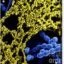

In [42]:
#img = Image.open("./test_img.png")
##convert to torch tensor
#img
imgL, imgAB = next(iter(dataloader))

#cat them together, convert to rgb and display
imgLAB = torch.cat((imgL,imgAB),dim=1)
imgRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(imgLAB).squeeze(0).detach().cpu()
            )
        )


imgRGB


In [44]:
%matplotlib widget
colorizer = ColorizerApp(imgRGB, diffusion_model, device)

colorizer.run()

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
hintgen = RandomHintGenerator(
    input_size = 256,
    hint_size =4)

masks = hintgen(batch_size = 1)
hints = get_color_hints(imgAB = imgAB, hints = masks, avg_color = True)
imgLAB_w_hints = torch.cat((imgL,hints),dim=1)
hintsRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(imgLAB_w_hints).detach().cpu()
            ).squeeze(0)
        )
hintsRGB



In [ ]:
outputAB = diffusion_model.sample(imgLAB_w_hints.to(device))

In [ ]:
outpuLAB = torch.cat((imgL,outputAB.to("cpu")),dim=1)
outputRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(outpuLAB).detach().cpu()
            ).squeeze(0))


outputRGB

In [ ]:
def get_new_dimensions(W, H, h):
    # calculate the new width while preserving the aspect ratio
    w = int((W * h) / H)
    # adjust the width to be divisible by 2 three times
    while w % 8 != 0:
        w -= 1
    return h, w
#convert to torch tensor
imgRGB = transforms.ToTensor()(img)
imgL = rgb_to_lab(imgRGB)[:1,:,:]


original_height, original_width = imgRGB.shape[1:]
print("original dimensions: ", original_height, original_width)
new_height, new_width = get_new_dimensions(original_width, original_height, 256)

imgRGB = transforms.Resize((new_height, new_width))(imgRGB)
print("new dimensions: ", imgRGB.shape[1:])





In [ ]:
#use ipywigdet linemagi
testImg = jimg#transforms.ToPILImage()(jimg)
testImg = testImg.convert('L').convert('RGB')

jupyter_colorizer = JupyterImageColorizer(testImg, diffusion_model,device=device)
jupyter_colorizer.display()


In [ ]:
7e-5+1

In [ ]:
colorizations_LAB = jupyter_colorizer.output_image_LAB_tensors

In [ ]:
colorizations_LAB =  transforms.Resize((original_height,original_width))(colorizations_LAB)
print(imgL.shape)
colorizations_LAB[:1,:1,:,:] = imgL

transforms.ToPILImage()(lab_to_rgb(colorizations_LAB).squeeze(0).detach().cpu())